# True vs Reco for interferometry

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pyrex
import pyrex.custom.ara as ara
from pyrex.internal_functions import normalize
import os
import sys
import seaborn as sns

sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree

# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

# import mplcyberpunk
# plt.style.use("cyberpunk")

current_palette = sns.color_palette('colorblind', 10)

Welcome to JupyROOT 6.18/04


In [2]:
def convertToLocal(posnu_x,posnu_y,posnu_z):
    posNu = np.array([posnu_x, posnu_y, posnu_z])
    avgVec = np.array([10000.83568, 9998.89765, 6359452.44702])
    posNu2 = posNu-avgVec #AraSim adds avgVec when transforming coordinates, and this is what AraSim outputs
    norm = np.linalg.norm(posNu2)
    posNu2 = posNu2/norm#Normalize
    posnu_theta = np.degrees(np.arccos((posNu2[2])))
    posnu_phi = np.degrees(np.arctan2(posNu2[1],posNu2[0])%(np.pi))
    return posnu_phi, posnu_theta

In [52]:
srcFolder = "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/Reco_sim/reco_code/Interf_files"
file_list=[]#Define an empty list
for filename in os.listdir(srcFolder):#Loop over desired directory
    if filename.endswith(".root"): #extension, .root in this case
        file_list.append(os.path.join(srcFolder, str(filename))) #add file name to the list
        

In [53]:
OutputTree = TChain("OutputTree")
for line in file_list:
    OutputTree.AddFile(line)

In [55]:
# for event in OutputTree:
#     print(event.[0])thirdVPeakOverRMS_out

In [64]:
phi_peak = []
theta_peak = []
posnu_phi = []
posnu_theta = []
peakV = []
SNR = []
weight = []
for event in OutputTree:
    corrValArray = np.zeros(4)
    corrValArray[0] = event.peakCorr_dir[0]
    corrValArray[1] = event.peakCorr_dir[1]
    corrValArray[2] = event.peakCorr_ref[0]
    corrValArray[3] = event.peakCorr_dir[1]
    maxBin = np.argmax(corrValArray)
#     print(maxBin)
    if(maxBin==0):
        theta_peak.append(90-event.peakTheta_dir[0])
        phi_peak.append(event.peakPhi_dir[0]%(180))
    elif(maxBin==1):
        theta_peak.append(90-event.peakTheta_dir[1])
        phi_peak.append(event.peakPhi_dir[1]%(180))
    elif(maxBin==2):
        theta_peak.append(90-event.peakTheta_ref[0])
        phi_peak.append(event.peakPhi_ref[0]%(180))
    elif(maxBin==3):
        theta_peak.append(90-event.peakTheta_ref[1])
        phi_peak.append(event.peakPhi_ref[1]%(180))
    phi, theta = convertToLocal(event.posnu[0],event.posnu[1],event.posnu[2])
    posnu_phi.append(phi)
    posnu_theta.append(theta)
    peakV.append(event.PeakVfromSim[0])
    SNR.append(event.thirdVPeakOverRMS_out[2])
    weight.append(event.weight)
        
#     print(event.peakPhi_dir[0],event.peakPhi_ref[0])

In [87]:
df = pd.DataFrame({"phi_peak":np.array(phi_peak),"theta_peak": np.array(theta_peak),"posnu_phi": np.array(posnu_phi),
                   "posnu_theta": np.array(posnu_theta),"SNR": np.array(SNR),  "weight":np.array(weight)})
df.tail()
df = df.loc[df.SNR>10]
# df = df.loc[df.posnu_theta>90]

Text(0.5,0,'$\\theta_{true}-\\theta_{reco}$')

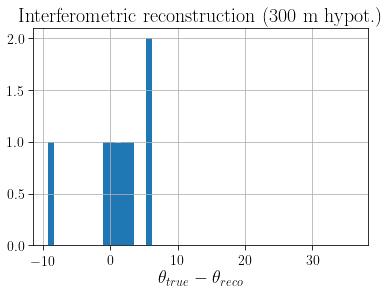

In [85]:
delta = df.posnu_theta-df.theta_peak
plt.hist(delta,bins=50, weights=df.weight);
plt.grid()
plt.title("Interferometric reconstruction (300 m hypot.)")
plt.xlabel(r"$\theta_{true}-\theta_{reco}$")
# plt.yscale("log")


Text(0.5,0,'$\\phi_{true}-\\phi_{reco}$')

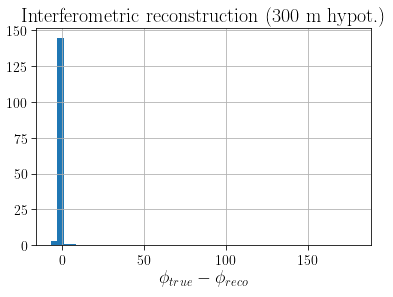

In [81]:
delta_phi = df.posnu_phi-df.phi_peak

plt.hist(delta_phi,bins=50, weights=df.weight);
plt.grid()
plt.title("Interferometric reconstruction (300 m hypot.)")
plt.xlabel(r"$\phi_{true}-\phi_{reco}$")
# plt.yscale("log")


In [31]:
interf = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/Reco_sim/reco_code/Interf_RecoVsTrue_simple.pkl")
interf = interf.loc[interf.maxAmplitude<1500]
interf = interf.loc[interf.maxAmplitude>500]

interf = interf.loc[interf.theta_reco>90]

interf.tail()

,EvNum,theta_reco,theta_true,phi_reco,phi_true,weight,maxAmplitude
1117,992021,93.0,98.521396,164.0,163.780311,1.168158e-04,809.613764
1118,992156,109.0,111.173859,127.0,126.753027,3.503074e-08,543.626240
1124,999719,117.0,118.171773,38.0,38.659708,4.266334e-09,535.852974
1125,1000579,96.0,99.759033,152.0,152.046855,9.987306e-01,590.628185
1126,1002024,116.0,116.448518,178.0,178.214368,9.953586e-01,851.932194


In [32]:
len(interf)

245

Text(0.5,0,'$\\theta_{true}-\\theta_{reco}$')

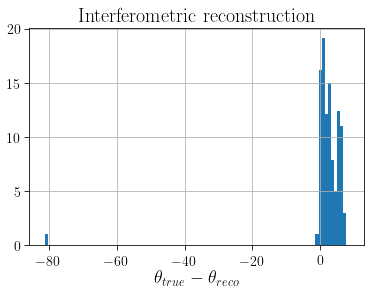

In [33]:
delta = np.array(interf.theta_true-interf.theta_reco)
plt.hist(delta, bins = 100, weights=interf.weight);
plt.grid()
plt.title("Interferometric reconstruction")
plt.xlabel(r"$\theta_{true}-\theta_{reco}$")
# plt.yscale("log")
# plt.xlim(-15,15)

In [34]:
delta.mean()

1.7337382998527866

Text(0.5,0,'$\\phi_{true}-\\phi_{reco}$')

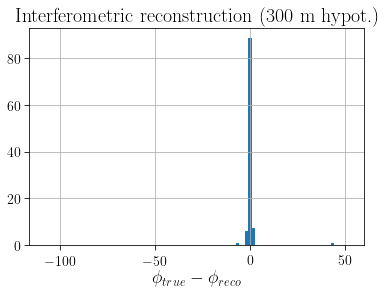

In [35]:
delta = np.array(interf.phi_true-interf.phi_reco)
plt.hist(delta, bins = 100, weights=interf.weight);
plt.grid()
plt.title("Interferometric reconstruction (300 m hypot.)")
plt.xlabel(r"$\phi_{true}-\phi_{reco}$")
# plt.yscale("log")
# plt.xlim(-15,15)

In [36]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

In [37]:
weighted_avg_and_std(delta, interf.weight)

(0.3845224004134849, 4.352910146845365)

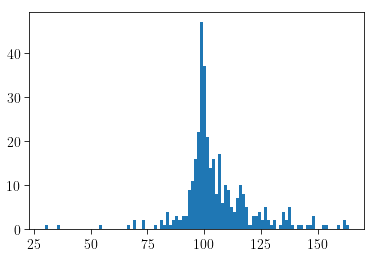

In [88]:
plt.hist(df.posnu_theta, bins = 100);

In [54]:
max(peakV)

0.34442322825847327